# Imputation Comparison

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ing-bank/probatus/blob/master/docs/tutorials/nb_imputation_comparison.ipynb)

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 500)
pd.set_option('display.max_colwidth', 200)

This notebook explains how the `CompareImputationStrategies` class works in `probatus`.

First let us import the class and other required classes.

In [5]:
from probatus.missing.imputation import CompareImputationStrategies
from probatus.utils.missing_helpers import generate_MCAR,get_data
import pandas as pd 
import lightgbm as lgb 
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import KNNImputer,SimpleImputer,IterativeImputer
from feature_engine.imputation import RandomSampleImputer


Currently `CompareImputationStrategies` supports any scikit learn compatible imputation strategies. For categorical variables the missing values are replaced by `missing` token and `OneHotEncoder` is applied.The user supplied imputation strategies are applied to numerical columns only. 
Support for user supplied imputation strategies for categorical columns can be added in the future releases.

Let's create some data on which we want to apply the various imputation strategies.We will create a dataset with both numerical and categorical variables.

In [12]:
X,y = get_data(n_samples=1000,n_numerical=10,n_category=5)
print(f"Shape of X,y : {X.shape},{y.shape}")

Shape of X,y : (1000, 15),(1000,)


Add missing values to the dataset. `generate_MCAR` method randomly adds missing values to the dataset.

In [13]:
X_missing = generate_MCAR(X,missing=0.2)
X_missing.isnull().mean()

f_0     0.207
f_1     0.205
f_2     0.212
f_3     0.207
f_4     0.197
f_5     0.205
f_6     0.201
f_7     0.219
f_8     0.200
f_9     0.211
f_10    0.193
f_11    0.226
f_12    0.192
f_13    0.207
f_14    0.193
dtype: float64

## Imputation Strategies

Create a dictionary with all the strategies to compare. Also, create a classifier that you want to use to evaluate various strategies.
If the model supports handling of missing features by default then the model performance on an unimputed dataset is calculated.
The model performance against the unimputed dataset can be found in `Model Imputation` results.

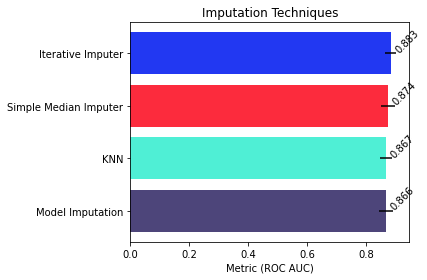

In [15]:
strategies = {
    'KNN' : KNNImputer(n_neighbors=3),
    'Simple Median Imputer' : SimpleImputer(strategy='median',add_indicator=True),
    'Iterative Imputer'  : IterativeImputer(add_indicator=True,n_nearest_features=5,
    sample_posterior=True)
    }
clf = lgb.LGBMClassifier()
cmp = CompareImputationStrategies(clf=clf,strategies=strategies,cv=5,random_state=45)
cmp.fit_compute(X_missing,y)
cmp.plot()

As can be seen with the above plot that, the `Iterative Imputer` strategy provide better model performance.

However if the model does not support missing values by default e.g LogisticRegression , results for only the inputation strategies are calculated. This can be indicated by setting the `model_na_support` parameter to `False`.


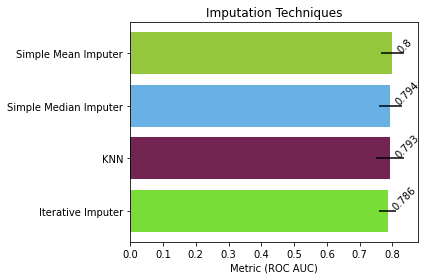

In [16]:
strategies = {
    'KNN' : KNNImputer(n_neighbors=3),
    'Simple Median Imputer' : SimpleImputer(strategy='median',add_indicator=True),
    'Simple Mean Imputer' : SimpleImputer(strategy='mean',add_indicator=False),
    'Iterative Imputer'  : IterativeImputer(add_indicator=True,n_nearest_features=5,
    sample_posterior=True)
    }
clf = LogisticRegression()
cmp = CompareImputationStrategies(clf=clf,strategies=strategies,cv=10,model_na_support=False)
cmp.fit_compute(X_missing,y)
cmp.plot()

You can also pass a sklearn pipline instead of a classifier.

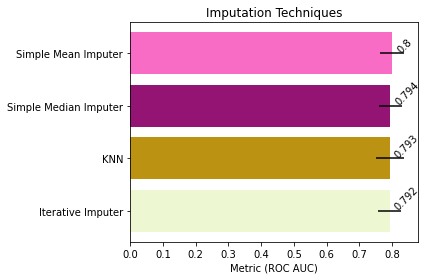

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
steps = [('scaler', StandardScaler()), ('LR', LogisticRegression())]
clf = Pipeline(steps)
cmp = CompareImputationStrategies(clf=clf,strategies=strategies,cv=10,model_na_support=False)
cmp.fit_compute(X_missing,y)
cmp.plot()


### Scikit Learn Compatible Imputers. 

You can also use any other scikit-learn compatible imputer as an imputing strategy.
eg. [feature engine](https://feature-engine.readthedocs.io/en/latest/index.html) library provides a host of other imputing stratgies as well. You can pass them for comparision. Let us try the `RandomSampleImputer`. You can read more about it [here](https://feature-engine.readthedocs.io/en/latest/imputation/RandomSampleImputer.html)

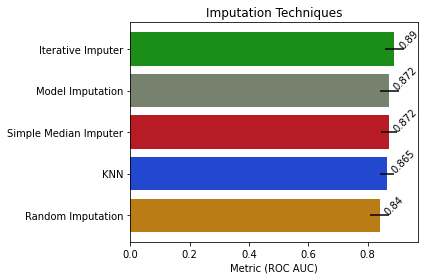

In [18]:
strategies = {
    'KNN' : KNNImputer(n_neighbors=3),
    'Simple Median Imputer' : SimpleImputer(strategy='median',add_indicator=True),
    'Iterative Imputer'  : IterativeImputer(add_indicator=True,n_nearest_features=5,
    sample_posterior=True),
    'Random Imputation' : RandomSampleImputer()
    }
clf = lgb.LGBMClassifier()
cmp = CompareImputationStrategies(clf=clf,strategies=strategies,cv=10)
cmp.fit_compute(X_missing,y)
cmp.plot()